In [36]:
import pandas
import numpy
import pygsheets
import scipy.stats
import datetime

import matplotlib
import matplotlib.pyplot as mp
import matplotlib.patheffects
import textwrap
import squarify

In [37]:
# set open sans as default font
mp.rcParams['font.family'] = 'Open Sans'

# gemplot variables

In [38]:
footer_color = "#222222"
footer_lineheight = 1.2
footer_fontsize = 14

# default height of a figure is 450 pixels

# gemstyle does this:
# specify a base_ratio, then set base_size = base_ratio*16
# 1. add 6 line margin all the way around
# 2. color of title is "#222222", margin 6666, size=base_size*1.5, lineheight=1.35, bold font
# 3. color of subtitle is "#333333", margin 0666, padding top=12, bottom=12, size=base_size*1.15, lineheight=1.45
# 4. set caption info as linehight=1.2, size=base_size*0.875, color="#222222", margin=18,6,6,6

base_ratio = 1.0
base_size = base_ratio * 16
color_title = "#222222"
color_subtitle = "#333333"
color_grid = "#cbcbcb"

text_weight_normal = 400
text_weight_bold = 700

# save fig
#' @keywords save_gem_plot
#' @examples
#' save_gem_plot(
#' plot_grid = line_plot_with_gem_footer,
#' save_filepath = "filename_that_my_plot_should_be_saved_to-nc.png",
#' width_pixels = 770,
#' height_pixels = 540,
#' resolution = 4
#' )
#'
#' @export
# save plot function - now separated from finalise_plot function and setting the resolution as part of the arguments
# save_gem_plot <- function (plot_grid, save_filepath, width_pixels = 640, height_pixels = 450, resolution = 3) {
#   grid::grid.draw(plot_grid)

#   #save it
#   ggplot2::ggsave(plot=plot_grid,
#                   width= (width_pixels/72),
#                   height= (height_pixels/72),
#                   dpi = resolution * 100,
#                   filename = save_filepath,
#                   bg="white")
# }

#width_pixels = 640 # default
#height_pixels = 450 # default

## colors

In [39]:
# sel_cmap = matplotlib.colormaps['Reds']
# tracker_operating = sel_cmap(0.999)
# tracker_construction = sel_cmap(0.8)
# tracker_proposed = sel_cmap(0.6)
# tracker_shelved = sel_cmap(0.4)
# tracker_cancelled = sel_cmap(0.2)

tracker_construction = '#761200'
tracker_proposed = '#bf532c'
tracker_shelved = '#e3710c'
#tracker_cancelled = '#357a5d'
#tracker_cancelled = '#4e8a71'
tracker_cancelled = '#9abcae'

## import terminals data from sheet

In [40]:
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
#spreadsheet = gc.open_by_key('1fNf3eK_nqgzXX6ijGlg9A4MPXAF4fh9ZmH3XnsrvS9A') # copy for 2022 report
spreadsheet = gc.open_by_key('1tcS6Wd-Wp-LTDpLzFgJY_RSNDnbyubW3J_9HKIAys4A')

#spreadsheet[1] "Gas Pipelines" tab is the second index
terms_df_orig = spreadsheet.worksheet('title', 'Terminals').get_as_df(start='A3')
region_df_orig = spreadsheet.worksheet('title', 'Country dictionary').get_as_df(start='A2')

In [41]:
region_df_orig_cleaned = region_df_orig.loc[(region_df_orig.Region!='--')&
                                            (region_df_orig.SubRegion!='--')]
multiindex_region_subregion = region_df_orig_cleaned.groupby(['Region','SubRegion'])['Country'].count().index
multiindex_region_subregion_country = region_df_orig_cleaned.groupby(['Region','SubRegion','Country'])['Country'].count().index

In [42]:
multiindex_region_subregion

MultiIndex([(  'Africa',                 'Northern Africa'),
            (  'Africa',              'Sub-Saharan Africa'),
            ('Americas', 'Latin America and the Caribbean'),
            ('Americas',                'Northern America'),
            (    'Asia',                    'Central Asia'),
            (    'Asia',                    'Eastern Asia'),
            (    'Asia',              'South-eastern Asia'),
            (    'Asia',                   'Southern Asia'),
            (    'Asia',                    'Western Asia'),
            (  'Europe',                  'Eastern Europe'),
            (  'Europe',                 'Northern Europe'),
            (  'Europe',                 'Southern Europe'),
            (  'Europe',                  'Western Europe'),
            ( 'Oceania',       'Australia and New Zealand'),
            ( 'Oceania',                       'Melanesia'),
            ( 'Oceania',                      'Micronesia'),
            ( 'Oceania',

In [43]:
# replace all -- with nans
terms_df_orig.replace('--', numpy.nan, inplace=True)
# remove oil export terminals
terms_df_orig = terms_df_orig.loc[terms_df_orig['Fuel']=='LNG']
# remove anything without a wiki page
terms_df_orig = terms_df_orig.loc[terms_df_orig['Wiki']!='']
# remove N/A statuses
terms_df_orig = terms_df_orig.loc[terms_df_orig['Status']!='']

In [44]:
status_list = ['Proposed', 
               'Construction', 
               'Shelved', 
               'Cancelled', 
               'Operating', 
               'Idle', 
               'Mothballed', 
               'Retired']
country_list = sorted(set(region_df_orig['Country'].tolist()))
region_list = sorted(set(region_df_orig['Region'].tolist()))
if '--' in region_list:
    region_list.remove('--')
subregion_list = sorted(set(region_df_orig['SubRegion'].tolist()))
if '--' in subregion_list:
    subregion_list.remove('--')

## table for exports

In [45]:
#mtpa by country

mtpa_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
mtpa_by_region_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion)

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                   (terms_df_orig['FacilityType']=='Export')&
                                                   (terms_df_orig.Status==status)]
    mtpa_by_country_df[status] = temp_df.groupby('Country')['CapacityInMtpa'].sum()

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                  (terms_df_orig['FacilityType']=='Export')&
                                                  (terms_df_orig.Status==status)]
    mtpa_by_region_df[status] = temp_df.groupby(['Region','SubRegion'])['CapacityInMtpa'].sum()

mtpa_by_country_df = mtpa_by_country_df.fillna(0)
mtpa_by_region_df = mtpa_by_region_df.fillna(0)

# add total and proposed+construction info
mtpa_by_region_df['Proposed+Construction'] = mtpa_by_region_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_region_df = mtpa_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

mtpa_by_country_df['Proposed+Construction'] = mtpa_by_country_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_country_df = mtpa_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

mtpa_by_region_df.index.names = ['Region','Subregion']
mtpa_by_region_df.sort_index(level='Region', inplace=True)

mtpa_by_region_df.to_excel('global-export-capacity-totals.xlsx')
#mtpa_by_region_df = mtpa_by_region_df.loc[~(mtpa_by_region_df==0).all(axis=1)]

# total
mtpa_by_region_df.loc['Total',:] = mtpa_by_region_df.sum(axis=0).values
mtpa_by_country_df.loc['Total',:] = mtpa_by_country_df.sum(axis=0).values

# save countries
mtpa_by_country_df = mtpa_by_country_df.loc[~(mtpa_by_country_df==0).all(axis=1)]
mtpa_by_country_df = mtpa_by_country_df.loc[mtpa_by_country_df['Proposed+Construction']!=0]
mtpa_by_country_df.replace(0,'',inplace=True)
mtpa_by_country_df.to_excel('mtpa-by-country-export.xlsx')

# mtpa_by_region_df = mtpa_by_region_df.loc[~(mtpa_by_region_df==0).all(axis=1)]
mtpa_by_region_export_df = mtpa_by_region_df.copy()

mtpa_by_region_df.replace(0,'')

Proposed Construction  \
Region   Subregion                                               
Africa   Northern Africa                                  0.07   
         Sub-Saharan Africa                102.55        13.52   
Americas Latin America and the Caribbean    89.56         7.45   
         Northern America                  322.58        90.11   
Asia     Central Asia                                            
         Eastern Asia                                            
         South-eastern Asia                  16.7                
         Southern Asia                                    10.8   
         Western Asia                       30.75         33.0   
Europe   Eastern Europe                     131.4         32.7   
         Northern Europe                                         
         Southern Europe                                         
         Western Europe                                          
Oceania  Australia and New Zealand           21.7          5.0   
         Melanesia                            9.2                
         Micronesia                                              
         Polynesia                                               
Total                                      724.44       192.65   

                                         Proposed+Construction Shelved  \
Region   Subregion                                                       
Africa   Northern Africa                                  0.07           
         Sub-Saharan Africa                             116.07    10.0   
Americas Latin America and the Caribbean                 97.01           
         Northern America                               412.69     6.0   
Asia     Central Asia                                                    
         Eastern Asia                                                    
         South-eastern Asia                               16.7           
         Southern Asia                                    10.8           
         Western Asia                                    63.75    22.0   
Europe   Eastern Europe                                  164.1    16.2   
         Northern Europe                                                 
         Southern Europe                                                 
         Western Europe                                                  
Oceania  Australia and New Zealand                        26.7     7.2   
         Melanesia                                         9.2     1.5   
         Micronesia                                                      
         Polynesia                                                       
Total                                                   917.09    62.9   

                                         Cancelled Operating   Idle  \
Region   Subregion                                                    
Africa   Northern Africa                       5.0     37.54          
         Sub-Saharan Africa                  27.39     37.72          
Americas Latin America and the Caribbean      21.6     16.45          
         Northern America                   460.82     92.92          
Asia     Central Asia                                    0.2          
         Eastern Asia                                                 
         South-eastern Asia                   2.95     52.55    9.6   
         Southern Asia                       63.95                    
         Western Asia                        22.64      95.4          
Europe   Eastern Europe                      16.36     31.06   3.76   
         Northern Europe                                4.67          
         Southern Europe                                              
         Western Europe                                               
Oceania  Australia and New Zealand            45.8      87.6          
         Melanesia                             6.0       8.3          
         Micronesia             

In [46]:
mtpa_by_country_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
United States,262.88,74.01,336.89,6.0,185.62,92.87,,1.5,
Russia,131.4,32.7,164.10,16.2,16.36,31.06,3.76,,
Canada,59.7,16.1,75.80,,275.2,0.05,,,
Mexico,61.86,7.45,69.31,,5.0,,,,
Qatar,16.0,33.0,49.00,,,77.4,,,
Mozambique,47.3,,47.30,,,3.4,,,
Australia,21.7,5.0,26.70,7.2,45.8,87.6,,,
Argentina,25.0,,25.00,,,,,0.45,
Nigeria,15.85,8.0,23.85,,22.0,23.02,,,
Mauritania,13.0,2.52,15.52,,,,,,


## table for imports

In [47]:
#mtpa by country

mtpa_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
mtpa_by_region_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion)

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                   (terms_df_orig['FacilityType']=='Import')&
                                                   (terms_df_orig.Status==status)]
    mtpa_by_country_df[status] = temp_df.groupby('Country')['CapacityInMtpa'].sum()

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                  (terms_df_orig['FacilityType']=='Import')&
                                                  (terms_df_orig.Status==status)]
    mtpa_by_region_df[status] = temp_df.groupby(['Region','SubRegion'])['CapacityInMtpa'].sum()

mtpa_by_country_df = mtpa_by_country_df.fillna(0)
mtpa_by_region_df = mtpa_by_region_df.fillna(0)

# add total and proposed+construction info
mtpa_by_region_df['Proposed+Construction'] = mtpa_by_region_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_region_df = mtpa_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

mtpa_by_country_df['Proposed+Construction'] = mtpa_by_country_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_country_df = mtpa_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

mtpa_by_region_df.index.names = ['Region','Subregion']
mtpa_by_region_df.sort_index(level='Region', inplace=True)

mtpa_by_region_df.to_excel('global-import-capacity-totals.xlsx')
#mtpa_by_region_df = mtpa_by_region_df.loc[~(mtpa_by_region_df==0).all(axis=1)]

# total
mtpa_by_region_df.loc['Total',:] = mtpa_by_region_df.sum(axis=0).values
mtpa_by_country_df.loc['Total',:] = mtpa_by_country_df.sum(axis=0).values

# save countries
mtpa_by_country_df = mtpa_by_country_df.loc[~(mtpa_by_country_df==0).all(axis=1)]
mtpa_by_country_df = mtpa_by_country_df.loc[mtpa_by_country_df['Proposed+Construction']!=0]
mtpa_by_country_df.replace(0,'',inplace=True)
mtpa_by_country_df.to_excel('mtpa-by-country-import.xlsx')

# mtpa_by_region_df = mtpa_by_region_df.loc[~(mtpa_by_region_df==0).all(axis=1)]
mtpa_by_region_import_df = mtpa_by_region_df.copy()

mtpa_by_region_df.replace(0,'')

Proposed Construction  \
Region   Subregion                                               
Africa   Northern Africa                                         
         Sub-Saharan Africa                   1.5          4.2   
Americas Latin America and the Caribbean    40.88        16.06   
         Northern America                    0.05                
Asia     Central Asia                                            
         Eastern Asia                      195.15        113.2   
         South-eastern Asia                  38.0          8.6   
         Southern Asia                      67.36         30.0   
         Western Asia                                      2.0   
Europe   Eastern Europe                      4.49         1.54   
         Northern Europe                    34.37          3.8   
         Southern Europe                    45.95         4.04   
         Western Europe                     66.64        19.24   
Oceania  Australia and New Zealand            8.3         2.33   
         Melanesia                                               
         Micronesia                                              
         Polynesia                                               
Total                                      502.69       205.01   

                                         Proposed+Construction Shelved  \
Region   Subregion                                                       
Africa   Northern Africa                                          6.15   
         Sub-Saharan Africa                                5.7    0.88   
Americas Latin America and the Caribbean                 56.94   16.28   
         Northern America                                 0.05           
Asia     Central Asia                                                    
         Eastern Asia                                   308.35   40.26   
         South-eastern Asia                               46.6    27.9   
         Southern Asia                                   97.36   25.54   
         Western Asia                                      2.0    11.1   
Europe   Eastern Europe                                   6.03    9.31   
         Northern Europe                                 38.17           
         Southern Europe                                 49.99    2.65   
         Western Europe                                  85.88           
Oceania  Australia and New Zealand                       10.63     1.0   
         Melanesia                                                       
         Micronesia                                                      
         Polynesia                                                       
Total                                                    707.7  141.07   

                                         Cancelled Operating  Idle Mothballed  \
Region   Subregion                                                              
Africa   Northern Africa                     10.64             5.7        4.2   
         Sub-Saharan Africa                    7.7                              
Americas Latin America and the Caribbean     24.97     77.14                    
         Northern America                   259.52      59.8  25.0       45.0   
Asia     Central Asia                                                           
         Eastern Asia                        52.17    532.35              1.5   
         South-eastern Asia                  35.17     58.15              0.4   
         Southern Asia                       72.45      65.5                    
         Western Asia                          8.0      72.8  22.9              
Europe   Eastern Europe                        7.3      4.58                    
         Northern Europe                     27.16     43.78                    
         Southern Europe                     47.68     79.91                    
         Western Europe                       12.4      72.0                    
Oceania  Australia and N

In [48]:
mtpa_by_country_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
China,168.85,99.0,267.85,28.66,43.6,123.01,,,
India,45.2,30.0,75.20,6.0,45.7,47.5,,,
Germany,52.14,13.24,65.38,,,17.28,,,
Brazil,34.37,14.76,49.13,11.28,,31.2,,,
Taiwan,22.8,11.8,34.60,,,15.5,,,
Italy,22.98,,22.98,,31.58,16.5,,,
Philippines,14.6,6.8,21.40,,2.2,5.0,,,
Greece,15.07,4.04,19.11,,,5.1,,,
United Kingdom,14.01,3.8,17.81,,20.0,35.5,,,3.0
Pakistan,14.9,,14.90,6.58,8.0,10.4,,,


## stacked bar charts for FacilityType capacity

# cost calculations

## create offshore and floating dfs

## define quantiles

make empty est cost column to fill in costs

In [116]:
terms_df_floating = terms_df_orig.loc[(terms_df_orig.Floating=='yes')&
                                      ~(terms_df_orig.CostUSDPerMtpa.isnull())]
terms_df_onshore = terms_df_orig.loc[(terms_df_orig.Floating=='')&
                                    ~(terms_df_orig.CostUSDPerMtpa.isnull())]

orig_num_floating = terms_df_floating.shape[0]
orig_num_onshore = terms_df_onshore.shape[0]

# terminal costs are calculated separately for offshore and onshore
# export terminals are about 2x as expensive as import terminals to build
# try removing top/bottom 2.5%?
qlo_val = 0.1
qhi_val = 0.9

qlo_floating = terms_df_floating['CostUSDPerMtpa'].quantile(qlo_val)
qhi_floating = terms_df_floating['CostUSDPerMtpa'].quantile(qhi_val)
qlo_onshore = terms_df_onshore['CostUSDPerMtpa'].quantile(qlo_val)
qhi_onshore = terms_df_onshore['CostUSDPerMtpa'].quantile(qhi_val)
# REMOVE EVERYTHING OUTSIDE OF THOSE QUANTILES
terms_df_floating = terms_df_floating.loc[terms_df_floating['CostUSDPerMtpa'].between(qlo_floating,qhi_floating,inclusive='both')]
terms_df_onshore = terms_df_onshore.loc[terms_df_onshore['CostUSDPerMtpa'].between(qlo_onshore,qhi_onshore,inclusive='both')]

# REMOVING ANYTHING OVER 1 billion per mtpa
# terms_df_floating = terms_df_floating.loc[terms_df_floating.CostUSDPerMtpa<1e9]
# terms_df_onshore = terms_df_onshore.loc[terms_df_onshore.CostUSDPerMtpa<1e9]

new_num_floating = terms_df_floating.shape[0]
new_num_onshore = terms_df_onshore.shape[0]

In [117]:
new_num_floating/orig_num_floating

0.8061224489795918

In [118]:
new_num_onshore/orig_num_onshore

0.7992831541218638

array([[<Axes: title={'center': 'CostUSDPerMtpa'}>]], dtype=object)

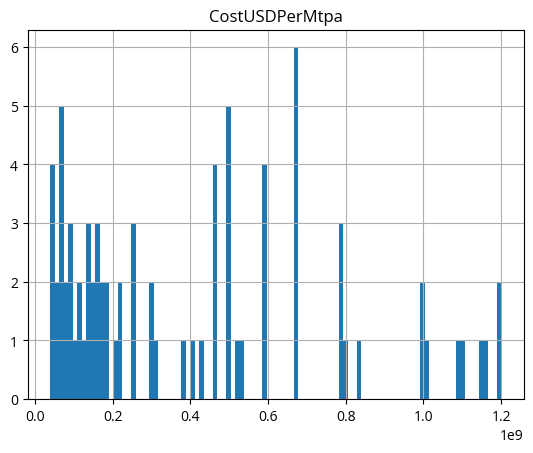

In [119]:
terms_df_floating.hist('CostUSDPerMtpa', bins=100)

array([[<Axes: title={'center': 'CostUSDPerMtpa'}>]], dtype=object)

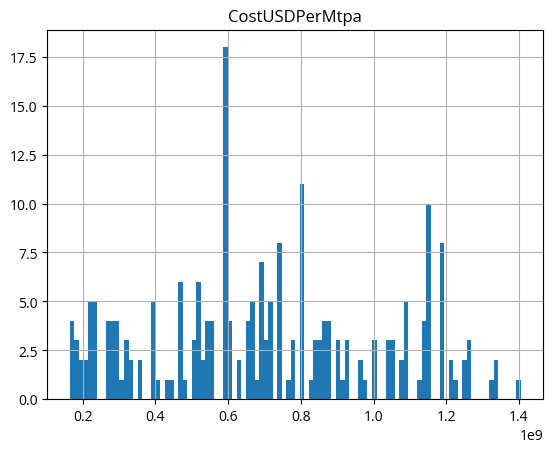

In [120]:
terms_df_onshore.hist('CostUSDPerMtpa', bins=100)

create a "noexpansions" dataframe that removes all expansion projects (assuming these will throw off cost calculations) and only keep one cost data point from each unique TerminalName

In [121]:
terms_df_floating_noexpansions = terms_df_floating#.loc[~terms_df_floating['UnitName'].str.contains('Expansion', na=False)].drop_duplicates(subset=['TerminalID'], keep='first')
terms_df_onshore_noexpansions = terms_df_onshore#.loc[~terms_df_onshore['UnitName'].str.contains('Expansion', na=False)].drop_duplicates(subset=['TerminalID'], keep='first')

## import

In [122]:
terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Import')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide()

TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Klaipeda FSRU,Lithuania,Operating,https://www.gem.wiki/Klaipeda_FSRU,39586206.900000
Skulte LNG Terminal,Latvia,Proposed,https://www.gem.wiki/Skulte_FRU,39966666.670000
NextDecade Cork FSRU,Ireland,Cancelled,https://www.gem.wiki/NextDecade_Cork_FSRU,46324995.680000
Moheshkhali FLNG Terminal (Petrobangla),Bangladesh,Operating,https://www.gem.wiki/Moheshkhali_FLNG_Terminal_(Petrobangla),47236842.110000
H-Energy Kakinada LNG Terminal,India,Proposed,https://www.gem.wiki/H-Energy_Kakinada_LNG_Terminal,52000000.000000
Philippines LNG Terminal,Philippines,Operating,https://www.gem.wiki/Philippines_LNG_Terminal,52560000.000000
Mumbai FSRU,India,Shelved,https://www.gem.wiki/Mumbai_FSRU,69940000.000000
LNG Alliance Mangalore FSRU,India,Proposed,https://www.gem.wiki/LNG_Alliance_Mangalore_FSRU,72500000.000000
Geelong FSRU Terminal,Australia,Proposed,https://www.gem.wiki/Geelong_FSRU,72637200.000000
Argo FSRU,Greece,Proposed,https://www.gem.wiki/Argo_FSRU_Terminal,72992080.140000


In [123]:
terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Import')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide()

TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Mugardos LNG Terminal,Spain,Shelved,https://www.gem.wiki/Mugardos_LNG_Terminal,164711095.740000
Mariveles LNG Terminal,Philippines,Proposed,https://www.gem.wiki/Mariveles_LNG_Terminal,167500000.000000
Pengerang Johor LNG Terminal,Malaysia,Operating,https://www.gem.wiki/Pengerang_Johur_LNG_Terminal,169714285.710000
Cacouna LNG Terminal,Canada,Cancelled,https://www.gem.wiki/Cacouna_LNG_Terminal,173684210.530000
Porto Empedocle LNG Terminal,Italy,Proposed,https://www.gem.wiki/Porto_Empedocle_LNG_Terminal,185299982.710000
Brunsbüttel LNG Terminal,Germany,Construction,https://www.gem.wiki/Brunsb%C3%BCttel_LNG_Terminal,185299982.710000
Zhejiang Energy Liuheng LNG Terminal,China,Proposed,https://www.gem.wiki/Zhejiang_Energy_Liuheng_LNG_Terminal,188976377.950000
Haldia LNG Terminal,India,Cancelled,https://www.gem.wiki/Haldia_LNG_Terminal,195000000.000000
Chaozhou LNG Terminal (Huaying）,China,Construction,https://www.gem.wiki/Chaozhou_LNG_Terminal_(Huaying),197306666.670000
Gate LNG Terminal,Netherlands,Proposed,https://www.gem.wiki/Gate_LNG_Terminal,205631980.810000


## export list

In [124]:
terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Export')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide()

TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Atlantic LNG Terminal,Trinidad and Tobago,Mothballed,https://www.gem.wiki/Atlantic_LNG_Terminal,217821781.820000
Atlantic LNG Terminal,Trinidad and Tobago,Operating,https://www.gem.wiki/Atlantic_LNG_Terminal,217821782.350000
Atlantic LNG Terminal,Trinidad and Tobago,Operating,https://www.gem.wiki/Atlantic_LNG_Terminal,217821782.350000
Atlantic LNG Terminal,Trinidad and Tobago,Operating,https://www.gem.wiki/Atlantic_LNG_Terminal,230769230.770000
Qatargas 1 Ras Laffan LNG Terminal,Qatar,Operating,https://www.gem.wiki/Qatargas_1_Ras_Laffan_LNG_Terminal,232323232.120000
Qatargas 1 Ras Laffan LNG Terminal,Qatar,Operating,https://www.gem.wiki/Qatargas_1_Ras_Laffan_LNG_Terminal,232323232.120000
Qatargas 1 Ras Laffan LNG Terminal,Qatar,Operating,https://www.gem.wiki/Qatargas_1_Ras_Laffan_LNG_Terminal,232323232.120000
Egyptian LNG Terminal,Egypt,Operating,https://www.gem.wiki/ELNG_IDCO_Terminal,268055555.560000
Oman Qalhat LNG Terminal,Oman,Operating,https://www.gem.wiki/Oman_Qalhat_LNG_Terminal,281690140.850000
Oman Qalhat LNG Terminal,Oman,Operating,https://www.gem.wiki/Oman_Qalhat_LNG_Terminal,281690140.850000


In [125]:
terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Export')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide()

TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Marshal Vasilevskiy FSRU,Russia,Idle,https://www.gem.wiki/Marshal_Vasilevskiy_FSRU,156493136.080000
Gorskaya FLNG Terminal,Russia,Cancelled,https://www.gem.wiki/Gorskaya_FLNG_Terminal,248642857.140000
Gorskaya FLNG Terminal,Russia,Cancelled,https://www.gem.wiki/Gorskaya_FLNG_Terminal,248642857.140000
Gorskaya FLNG Terminal,Russia,Cancelled,https://www.gem.wiki/Gorskaya_FLNG_Terminal,248642857.140000
Djibouti FLNG Terminal,Djibouti,Shelved,https://www.gem.wiki/Djibouti_FLNG_Terminal,300000000.000000
New Fortress Altamira FLNG Terminal,Mexico,Construction,https://www.gem.wiki/New_Fortress_Altamira_FLNG_Terminal,309523809.290000
Etinde FLNG Terminal,Cameroon,Proposed,https://www.gem.wiki/Etinde_FLNG_Terminal,384615384.620000
Djibouti FLNG Terminal,Djibouti,Shelved,https://www.gem.wiki/Djibouti_FLNG_Terminal,400000000.000000
Greater Tortue Ahmeyim FLNG Terminal,Mauritania,Construction,https://www.gem.wiki/Greater_Tortue_Ahmeyim_FLNG,463680000.000000
Greater Tortue Ahmeyim FLNG Terminal,Mauritania,Construction,https://www.gem.wiki/Greater_Tortue_Ahmeyim_FLNG,463680000.000000


### make dataframe to use for terminal calculations

* use regional averages for onshore terminals
* Subregions will inherit larger Region values
  * if Region has fewer than 3 data points, then apply a global value rather than a regional one!
* global averages for offshore terminals

In [126]:
onshore_export_regional_costs = pandas.DataFrame(index=region_list)

onshore_export_regional_costs['NumberOfDataPoints'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Export')].groupby('Region')[['CostUSDPerMtpa']].count()


onshore_export_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Export')].groupby('Region')[['CostUSDPerMtpa']].mean()

onshore_export_regional_costs.loc[(onshore_export_regional_costs.NumberOfDataPoints<3) | 
                                  (onshore_export_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
    terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                       (terms_df_onshore_noexpansions['FacilityType']=='Export')][['CostUSDPerMtpa']].mean().values[0]

onshore_export_regional_costs = onshore_export_regional_costs.loc[~(onshore_export_regional_costs.index=='--')]

print('export onshore')
onshore_export_regional_costs

export onshore


,NumberOfDataPoints,RegionalCostUSDPerMtpa
Oceania,12,7.415215e+08
Africa,11,7.287717e+08
Europe,13,1.161147e+09
Asia,26,8.149976e+08
Americas,121,7.367574e+08


In [127]:
terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Export')&
                                   (terms_df_onshore_noexpansions.Region=='North America')].to_excel('terminals_df_onshore_export.xlsx', index=False)

In [128]:
a = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Export')&
                                    (terms_df_onshore_noexpansions.Region=='North America')].TerminalID.unique()
for i in a:
    #print(terms_df_onshore_noexpansions.loc[terms_df_onshore_noexpansions.TerminalID==i]['TerminalName'])
    print(terms_df_onshore_noexpansions.loc[terms_df_onshore_noexpansions.TerminalID==i]['CostUSDPerMtpa'].values[0]/1e6)

In [129]:
onshore_import_regional_costs = pandas.DataFrame(index=region_list)

onshore_import_regional_costs['NumberOfDataPoints'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Import')].groupby('Region')[['CostUSDPerMtpa']].count()

onshore_import_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Import')].groupby('Region')[['CostUSDPerMtpa']].mean()

onshore_import_regional_costs.loc[(onshore_import_regional_costs.NumberOfDataPoints<3) | 
                                  (onshore_import_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
    terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                       (terms_df_onshore_noexpansions['FacilityType']=='Import')][['CostUSDPerMtpa']].mean().values[0]

onshore_import_regional_costs = onshore_import_regional_costs.loc[~(onshore_import_regional_costs.index=='--')]
print('import onshore')
onshore_import_regional_costs.replace(numpy.nan,0)

import onshore


,NumberOfDataPoints,RegionalCostUSDPerMtpa
Oceania,0.0,3.757319e+08
Africa,2.0,3.757319e+08
Europe,11.0,3.915713e+08
Asia,23.0,3.628154e+08
Americas,4.0,3.017544e+08


In [130]:
floating_export_regional_costs = pandas.DataFrame(index=region_list)

floating_export_regional_costs['NumberOfDataPoints'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Export')].groupby('Region')[['CostUSDPerMtpa']].count()

floating_export_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Export')].groupby('Region')[['CostUSDPerMtpa']].mean()

floating_export_regional_costs.loc[:,
                                #(floating_export_regional_costs.NumberOfDataPoints<3) | 
                                #  (floating_export_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
    terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                       (terms_df_floating_noexpansions['FacilityType']=='Export')][['CostUSDPerMtpa']].mean().values[0]

floating_export_regional_costs = floating_export_regional_costs.loc[~(floating_export_regional_costs.index=='--')]

print('export floating')
floating_export_regional_costs.replace(numpy.nan,0)

export floating


,NumberOfDataPoints,RegionalCostUSDPerMtpa
Oceania,0.0,6.304818e+08
Africa,16.0,6.304818e+08
Europe,4.0,6.304818e+08
Asia,4.0,6.304818e+08
Americas,16.0,6.304818e+08


In [131]:
floating_import_regional_costs = pandas.DataFrame(index=region_list)

floating_import_regional_costs['NumberOfDataPoints'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Import')].groupby('Region')[['CostUSDPerMtpa']].count()

floating_import_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Import')].groupby('Region')[['CostUSDPerMtpa']].mean()

floating_import_regional_costs.loc[:,
                                   #(floating_import_regional_costs.NumberOfDataPoints<3) | 
                                  #(floating_import_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
    terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                       (terms_df_floating_noexpansions['FacilityType']=='Import')][['CostUSDPerMtpa']].mean().values[0]

floating_import_regional_costs = floating_import_regional_costs.loc[~(floating_import_regional_costs.index=='--')]

print('import floating')
floating_import_regional_costs.replace(numpy.nan,0)

import floating


,NumberOfDataPoints,RegionalCostUSDPerMtpa
Oceania,4.0,1.906691e+08
Africa,2.0,1.906691e+08
Europe,20.0,1.906691e+08
Asia,13.0,1.906691e+08
Americas,0.0,1.906691e+08


### global calculations

In [65]:
cost_onshore_export = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Export')][['CostUSDPerMtpa']].mean().values
cost_onshore_export_mdn = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Export')][['CostUSDPerMtpa']].median().values
cost_onshore_export_std = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Export')][['CostUSDPerMtpa']].std().values

cost_floating_export = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Export')][['CostUSDPerMtpa']].mean().values
cost_floating_export_mdn = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Export')][['CostUSDPerMtpa']].median().values
cost_floating_export_std = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Export')][['CostUSDPerMtpa']].std().values

cost_onshore_import = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Import')][['CostUSDPerMtpa']].mean().values
cost_onshore_import_mdn = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Import')][['CostUSDPerMtpa']].median().values
cost_onshore_import_std = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Import')][['CostUSDPerMtpa']].std().values

cost_floating_import = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Import')][['CostUSDPerMtpa']].mean().values
cost_floating_import_mdn = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Import')][['CostUSDPerMtpa']].median().values
cost_floating_import_std = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Import')][['CostUSDPerMtpa']].std().values

In [66]:
cost_onshore_export

array([7.77853754e+08])

In [67]:
cost_onshore_export_mdn

array([7.40740741e+08])

In [68]:
cost_onshore_export_std

array([2.84732928e+08])

In [69]:
cost_floating_export

array([6.30481758e+08])

In [70]:
cost_floating_export_mdn

array([5.92592593e+08])

In [71]:
cost_floating_export_std

array([2.72874763e+08])

In [72]:
cost_onshore_import

array([3.75731933e+08])

In [73]:
cost_onshore_import_mdn

array([2.96207486e+08])

In [74]:
cost_onshore_import_std

array([2.40085285e+08])

In [75]:
cost_floating_import

array([1.90669128e+08])

In [76]:
cost_floating_import_mdn

array([1.32067636e+08])

In [77]:
cost_floating_import_std

array([2.41846495e+08])

### calculate how much export/import capacity data we have

In [78]:
terms_df_costs_exist = terms_df_orig.loc[~terms_df_orig.CostUSDPerMtpa.isnull()]
terms_df_costs_exist.to_excel('available-cost-data.xlsx', index=False)

In [79]:
#% of import terms that we have a capacity for?
print(terms_df_orig.loc[(terms_df_orig['FacilityType']=='Import')].shape)
print(terms_df_orig.loc[(terms_df_orig['FacilityType']=='Import')&
                  (~terms_df_orig['CapacityInMtpa'].isnull())].shape)
print(558/663 * 100)

(663, 81)
(558, 81)
84.16289592760181


In [80]:
#% of export terms that we have a capacity for?
print(terms_df_orig.loc[(terms_df_orig['FacilityType']=='Export')].shape)
print(terms_df_orig.loc[(terms_df_orig['FacilityType']=='Export')&
                  (~terms_df_orig['CapacityInMtpa'].isnull())].shape)
print(558/595 * 100)

(595, 81)
(568, 81)
93.78151260504201


## now calculate the import terminal costs

In [81]:
terms_df_import = terms_df_orig.loc[terms_df_orig['FacilityType']=='Import'].reset_index(drop=True)

terms_df_import['CostUSDTotal'] = numpy.nan

# for import
for region in region_list:
    # for floating
    terms_df_import.loc[(terms_df_import['Floating']=='yes')&(terms_df_import['Region']==region),'CostUSDTotal'] = \
    terms_df_import.loc[(terms_df_import['Floating']=='yes')&(terms_df_import['Region']==region),'CapacityInMtpa'] * \
    floating_import_regional_costs.loc[region,'RegionalCostUSDPerMtpa']
    # for onshore
    terms_df_import.loc[(terms_df_import['Floating']!='yes')&(terms_df_import['Region']==region),'CostUSDTotal'] = \
    terms_df_import.loc[(terms_df_import['Floating']!='yes')&(terms_df_import['Region']==region),'CapacityInMtpa'] * \
    onshore_import_regional_costs.loc[region,'RegionalCostUSDPerMtpa']   

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_import['CostUSD'].isna()
terms_df_import.loc[costs_exist_TF,'CostUSDTotal'] = \
    terms_df_import[costs_exist_TF]['CostUSD']

## and calculate export terminal costs

In [82]:
terms_df_export = terms_df_orig.loc[terms_df_orig['FacilityType']=='Export'].reset_index(drop=True)

terms_df_export['CostUSDTotal'] = numpy.nan

# for import
for region in region_list:
    # for floating
    terms_df_export.loc[(terms_df_export['Floating']=='yes')&(terms_df_export['Region']==region),'CostUSDTotal'] = \
    terms_df_export.loc[(terms_df_export['Floating']=='yes')&(terms_df_export['Region']==region),'CapacityInMtpa'] * \
    floating_export_regional_costs.loc[region,'RegionalCostUSDPerMtpa']
    # for onshore
    terms_df_export.loc[(terms_df_export['Floating']!='yes')&(terms_df_export['Region']==region),'CostUSDTotal'] = \
    terms_df_export.loc[(terms_df_export['Floating']!='yes')&(terms_df_export['Region']==region),'CapacityInMtpa'] * \
    onshore_export_regional_costs.loc[region,'RegionalCostUSDPerMtpa']   

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_export['CostUSD'].isna()
terms_df_export.loc[costs_exist_TF,'CostUSDTotal'] = \
    terms_df_export[costs_exist_TF]['CostUSD']

## import terminal costs table

In [83]:
#mtpa by country

cost_by_country_import_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion_country)
cost_by_region_import_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion)

for status in status_list:
    #print(status)
    cost_by_country_import_df[status] = terms_df_import.loc[terms_df_import.Status==status].groupby(['Region','SubRegion','Country'])['CostUSDTotal'].sum()

for status in status_list:
    #print(status)
    cost_by_region_import_df[status] = terms_df_import.loc[terms_df_import.Status==status].groupby(['Region','SubRegion'])['CostUSDTotal'].sum()

cost_by_country_import_df = cost_by_country_import_df.fillna(0)
cost_by_region_import_df = cost_by_region_import_df.fillna(0)

# add total and proposed+construction info
cost_by_region_import_df['Proposed+Construction'] = cost_by_region_import_df[['Proposed','Construction']].sum(axis=1)
cost_by_region_import_df = cost_by_region_import_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_region_import_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

cost_by_country_import_df['Proposed+Construction'] = cost_by_country_import_df[['Proposed','Construction']].sum(axis=1)
cost_by_country_import_df = cost_by_country_import_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_country_import_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

cost_by_region_import_df.index.names = ['Region','Subregion']
cost_by_country_import_df.index.names = ['Region','Subregion','Country']

# total
cost_by_region_import_df.loc[('Total',''),:] = cost_by_region_import_df.sum(axis=0)
cost_by_country_import_df.loc[('Total','',''),:] = cost_by_country_import_df.sum(axis=0)

# save countries
cost_by_country_import_df = cost_by_country_import_df.loc[~(cost_by_country_import_df==0).all(axis=1)]
cost_by_country_import_df.to_excel('cost-by-country-import.xlsx')

cost_by_region_import_df_full = cost_by_region_import_df.copy()
cost_by_region_import_df = cost_by_region_import_df.loc[~(cost_by_region_import_df==0).all(axis=1)]
cost_by_region_import_df = cost_by_region_import_df.sort_values('Region')

(cost_by_region_import_df/1e9).to_excel('cost-by-region-import-billionUSD.xlsx')
(cost_by_region_import_df/1e9).replace(0,'')

Proposed Construction  \
Region   Subregion                                                 
Africa   Sub-Saharan Africa                1.040669     0.826673   
         Northern Africa                                           
Americas Latin America and the Caribbean   6.642147     3.062146   
         Northern America                  0.015088                
Asia     Eastern Asia                     67.246443    38.720284   
         Southern Asia                    12.913084     7.735776   
         South-eastern Asia               12.384774     2.466057   
         Western Asia                                    0.36733   
Europe   Western Europe                   15.499549     3.128807   
         Southern Europe                   9.579469       0.3924   
         Northern Europe                   5.998995        0.763   
         Eastern Europe                      0.6758      0.60302   
Oceania  Australia and New Zealand         1.223012     0.181593   
Total                                     133.21903    58.247087   

                                         Proposed+Construction    Shelved  \
Region   Subregion                                                          
Africa   Sub-Saharan Africa                           1.867342   0.167789   
         Northern Africa                                         4.894035   
Americas Latin America and the Caribbean              9.704293   2.418731   
         Northern America                             0.015088              
Asia     Eastern Asia                               105.966728  12.459193   
         Southern Asia                                20.64886   6.221027   
         South-eastern Asia                           14.85083   9.749826   
         Western Asia                                  0.36733   2.116427   
Europe   Western Europe                              18.628356              
         Southern Europe                              9.971869      0.436   
         Northern Europe                              6.761995              
         Eastern Europe                                1.27882   2.980543   
Oceania  Australia and New Zealand                    1.404605   0.427833   
Total                                               191.466117  41.871403   

                                           Cancelled   Operating       Idle  \
Region   Subregion                                                            
Africa   Sub-Saharan Africa                 1.468152                          
         Northern Africa                    3.997788               1.086814   
Americas Latin America and the Caribbean    7.146009   17.656984              
         Northern America                  71.770485   16.415561   7.210604   
Asia     Eastern Asia                      18.411642  189.233794              
         Southern Asia                     18.459817   20.120734              
         South-eastern Asia                13.023573   11.596481              
         Western Asia                       2.902523    15.54362   4.213308   
Europe   Western Europe                     4.855484   20.560962              
         Southern Europe                   16.523821   29.407126              
         Northern Europe                    6.988431    15.17166              
         Eastern Europe                     1.210000    1.914244              
Oceania  Australia and New Zealand          0.181593                          
Total                                     166.939318  337.621167  12.510726   

                                         Mothballed   Retired  
Region   Subregion                                             
Africa   Sub-Saharan Africa                                    
         Northern Africa                    0.80081            
Americas Latin America and the Caribbean                       
         Northern America                 13.578947  5.220351  
Asia     Eastern Asia                      0.544223            
        

## export terminal costs table

In [84]:
#mtpa by country

cost_by_country_export_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion_country)
cost_by_region_export_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion)

for status in status_list:
    cost_by_country_export_df[status] = terms_df_export.loc[terms_df_export.Status==status].groupby(['Region','SubRegion','Country'])['CostUSDTotal'].sum()

for status in status_list:
    cost_by_region_export_df[status] = terms_df_export.loc[terms_df_export.Status==status].groupby(['Region','SubRegion'])['CostUSDTotal'].sum()

cost_by_country_export_df = cost_by_country_export_df.fillna(0)
cost_by_region_export_df = cost_by_region_export_df.fillna(0)

# add total and proposed+construction info
cost_by_region_export_df['Proposed+Construction'] = cost_by_region_export_df[['Proposed','Construction']].sum(axis=1)
cost_by_region_export_df = cost_by_region_export_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_region_export_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

cost_by_country_export_df['Proposed+Construction'] = cost_by_country_export_df[['Proposed','Construction']].sum(axis=1)
cost_by_country_export_df = cost_by_country_export_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_country_export_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

cost_by_region_export_df.index.names = ['Region','Subregion']

# total
cost_by_region_export_df.loc[('Total',''),:] = cost_by_region_export_df.sum(axis=0)
cost_by_country_export_df.loc[('Total','',''),:] = cost_by_country_export_df.sum(axis=0)

# save countries
cost_by_country_export_df = cost_by_country_export_df.loc[~(cost_by_country_export_df==0).all(axis=1)]
cost_by_country_export_df.to_excel('cost-by-country-export.xlsx')

cost_by_region_export_df_full = cost_by_region_export_df.copy()
cost_by_region_export_df = cost_by_region_export_df.loc[~(cost_by_region_export_df==0).all(axis=1)]
cost_by_region_export_df = cost_by_region_export_df.sort_values('Region')

(cost_by_region_export_df/1e9).to_excel('cost-by-region-export-billionUSD.xlsx')
(cost_by_region_export_df/1e9).replace(0,'')

Proposed Construction  \
Region   Subregion                                                  
Africa   Sub-Saharan Africa               128.971886     9.892751   
         Northern Africa                                 0.051014   
Americas Northern America                 244.121799    80.320976   
         Latin America and the Caribbean   78.556657     3.694461   
Asia     Western Asia                      25.375477        28.75   
         South-eastern Asia                25.667537                
         Southern Asia                                       10.0   
         Central Asia                                               
Europe   Eastern Europe                   153.597189    39.309029   
         Northern Europe                                            
Oceania  Australia and New Zealand         28.137671          5.6   
         Melanesia                          18.19663                
Total                                     702.624846   177.618231   

                                         Proposed+Construction    Shelved  \
Region   Subregion                                                          
Africa   Sub-Saharan Africa                         138.864636        4.0   
         Northern Africa                              0.051014              
Americas Northern America                           324.442775        4.0   
         Latin America and the Caribbean             82.251119              
Asia     Western Asia                                54.125477  17.929948   
         South-eastern Asia                          25.667537              
         Southern Asia                                    10.0              
         Central Asia                                                       
Europe   Eastern Europe                             192.906218  15.811468   
         Northern Europe                                                    
Oceania  Australia and New Zealand                   33.737671      17.25   
         Melanesia                                    18.19663   1.112282   
Total                                               880.243077  60.103699   

                                           Cancelled   Operating      Idle  \
Region   Subregion                                                           
Africa   Sub-Saharan Africa                20.083678   36.328732             
         Northern Africa                    3.643858   24.195933             
Americas Northern America                 335.956477   72.681043             
         Latin America and the Caribbean   14.626848    6.481188             
Asia     Western Asia                      23.093977   68.195815             
         South-eastern Asia                 2.404243   40.508965  7.823977   
         Southern Asia                     49.271638                         
         Central Asia                                      0.163             
Europe   Eastern Europe                    18.827625   47.621954     0.588   
         Northern Europe                                6.445739             
Oceania  Australia and New Zealand         33.688741  180.166337             
         Melanesia                              8.25        19.0             
Total                                     509.847087  501.788706  8.411977   

                                         Mothballed    Retired  
Region   Subregion                                              
Africa   Sub-Saharan Africa                                     
         Northern Africa                   2.332069   5.684419  
Americas Northern America                  1.105136             
         Latin America and the Caribbean   1.002529             
Asia     Western Asia                      5.867983             
         South-eastern Asia                          24.531429  
         Southern Asia                                          
         Central Asia                                           
Europe   Eastern Europe        

## add import + export costs together

In [85]:
region_order

NameError: name 'region_order' is not defined

In [86]:
region_order

NameError: name 'region_order' is not defined

In [87]:
cost_by_region_TOTAL = cost_by_region_import_df_full + cost_by_region_export_df_full

cost_by_region_TOTAL = cost_by_region_TOTAL.loc[~(cost_by_region_TOTAL==0).all(axis=1)]
(cost_by_region_TOTAL/1e9).to_excel('cost-by-region-TOTAL-billionUSD.xlsx')
(cost_by_region_TOTAL/1e9).replace(0,'')

Proposed Construction  \
Region   Subregion                                                  
Africa   Northern Africa                                 0.051014   
         Sub-Saharan Africa               130.012555    10.719423   
Americas Latin America and the Caribbean   85.198804     6.756608   
         Northern America                 244.136887    80.320976   
Asia     Central Asia                                               
         Eastern Asia                      67.246443    38.720284   
         South-eastern Asia                 38.05231     2.466057   
         Southern Asia                     12.913084    17.735776   
         Western Asia                      25.375477     29.11733   
Europe   Eastern Europe                   154.272989    39.912049   
         Northern Europe                    5.998995        0.763   
         Southern Europe                    9.579469       0.3924   
         Western Europe                    15.499549     3.128807   
Oceania  Australia and New Zealand         29.360683     5.781593   
         Melanesia                          18.19663                
Total                                     835.843876   235.865318   

                                         Proposed+Construction     Shelved  \
Region   Subregion                                                           
Africa   Northern Africa                              0.051014    4.894035   
         Sub-Saharan Africa                         140.731978    4.167789   
Americas Latin America and the Caribbean             91.955412    2.418731   
         Northern America                           324.457862         4.0   
Asia     Central Asia                                                        
         Eastern Asia                               105.966728   12.459193   
         South-eastern Asia                          40.518367    9.749826   
         Southern Asia                                30.64886    6.221027   
         Western Asia                                54.492807   20.046376   
Europe   Eastern Europe                             194.185038   18.792011   
         Northern Europe                              6.761995               
         Southern Europe                              9.971869       0.436   
         Western Europe                              18.628356               
Oceania  Australia and New Zealand                   35.142276   17.677833   
         Melanesia                                    18.19663    1.112282   
Total                                              1071.709194  101.975102   

                                           Cancelled   Operating       Idle  \
Region   Subregion                                                            
Africa   Northern Africa                    7.641646   24.195933   1.086814   
         Sub-Saharan Africa                21.551831   36.328732              
Americas Latin America and the Caribbean   21.772857   24.138173              
         Northern America                 407.726962   89.096604   7.210604   
Asia     Central Asia                                   0.163000              
         Eastern Asia                      18.411642  189.233794              
         South-eastern Asia                15.427816   52.105446   7.823977   
         Southern Asia                     67.731455   20.120734              
         Western Asia                      25.996501   83.739436   4.213308   
Europe   Eastern Europe                    20.037625   49.536198      0.588   
         Northern Europe                    6.988431   21.617399              
         Southern Europe                   16.523821   29.407126              
         Western Europe                     4.855484   20.560962              
Oceania  Australia and New Zealand         33.870334  180.166337              
         Melanesia                              8.25   19.000000              
Total                                     676.786405 

In [88]:
cost_by_region_TOTAL.groupby('Region').sum()/1e9

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Region,,,,,,,,,
Africa,130.012555,10.770437,140.782992,9.061824,29.193477,60.524665,1.086814,3.132880,5.684419
Americas,329.335690,87.077584,416.413274,6.418731,429.499819,113.234776,7.210604,15.686612,5.220351
Asia,143.587315,88.039447,231.626762,48.476421,127.567414,345.362410,12.037286,6.557332,24.531429
Europe,185.351002,44.196257,229.547259,19.228011,48.405361,121.121685,0.588000,0.000000,0.583619
Oceania,47.557313,5.781593,53.338906,18.790115,42.120334,199.166337,0.000000,0.000000,0.000000
Total,835.843876,235.865318,1071.709194,101.975102,676.786405,839.409874,20.922704,25.376824,36.019818


# TREEMAP PLOT FOR BRIEFING

Americas
Asia
Europe
Africa
Oceania


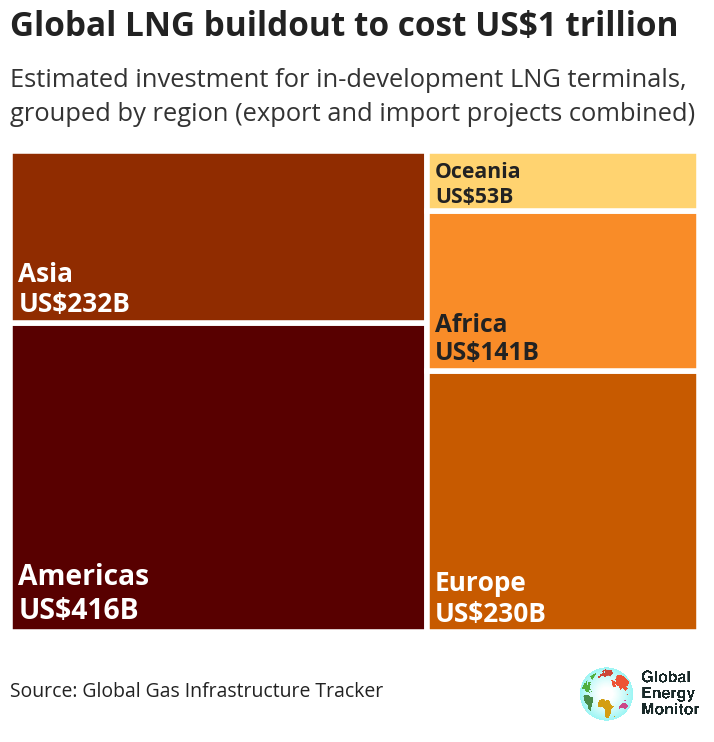

In [89]:
width_pixels = 640 # 640 default
height_pixels = 450 # 450 default
fig = mp.figure(figsize=(width_pixels/72, height_pixels/72))
fig.canvas.draw()
axis_text_color = '0.5'

ax=fig.add_subplot(111)
ax.axis('off')

which_status = 'Proposed+Construction'
subregion_divider_lw = 4
region_divider_lw = 4
divider_lc = '1'

# list is ordered from largest to smallest...
# it must be ordered properly
treemap_colors = {'Americas':'#580000',
                  'Asia':'#902c00',
                  'Europe':'#c75a00',
                  'Africa':'#f98c28',
                  'Oceania':'#ffd370'}

# # reorder cost_by_region
# # cost_by_region_TOTAL

# cost_by_region_TOTAL_toplot = cost_by_region_TOTAL.drop('Total')

# regional_sum_df = km_by_subregion_df_toplot.groupby(level='Region').sum()
# region_order = cost_by_region_TOTAL.sort_values(by='Proposed+Construction', ascending=False).index.values
# regional_sum_df = regional_sum_df.reindex(index=region_order)

# # sort first by construction values, THEN reorder based on region_order
# km_by_subregion_df_toplot = km_by_subregion_df_toplot.sort_values(
#     ['Region','Construction'], ascending=False).reindex(
#     level=0, index=region_order)

cost_by_region_TOTAL['Colors'] = str(numpy.nan)
for idx,row in cost_by_region_TOTAL.iterrows():
    if idx!=('Total',''):
        cost_by_region_TOTAL.loc[idx,'Colors'] = treemap_colors[idx[0]]

cost_by_region_TOTAL_sum = pandas.DataFrame(cost_by_region_TOTAL.drop('Total').groupby(
    ['Region','Colors'])[which_status].sum()).sort_values(
    which_status, ascending=False).reset_index(level=1)

cost_by_subregion_TOTAL_sum = pandas.DataFrame(cost_by_region_TOTAL.drop('Total').groupby(
    ['Region','Subregion'])[which_status].sum()).reset_index(level=1)

# cost_by_subregion_TOTAL_sum = cost_by_subregion_TOTAL_sum.sort_values(
#     ['Region',which_status], ascending=False).reindex(
#     level=0, index=region_order)

normalized_region_values = squarify.normalize_sizes(cost_by_region_TOTAL_sum[which_status].values,
                                                    dx=100,
                                                    dy=100)
squarified_region_values = squarify.squarify(normalized_region_values,
                                             0,
                                             0,
                                             100,
                                             100)

ax_bbox = ax.get_position() # gives x0, y0, xwidth, yheight
x_scale = ax_bbox.bounds[2]
y_scale = ax_bbox.bounds[3]

# region plot
squarify.plot(normalized_region_values,
              norm_x=100,
              norm_y=100,
              ax=ax,
              color=cost_by_region_TOTAL_sum.Colors.tolist(),
              linewidth=subregion_divider_lw,
              clip_on=False,
              edgecolor=divider_lc)

for i in range(len(squarified_region_values)):

    region_name = cost_by_region_TOTAL_sum.index.tolist()[i]
    print(region_name)

    ax_new = fig.add_axes([squarified_region_values[i]['x']/100*y_scale+ax_bbox.bounds[0],
                           squarified_region_values[i]['y']/100*y_scale+ax_bbox.bounds[1],
                           squarified_region_values[i]['dx']/100*x_scale,
                           squarified_region_values[i]['dy']/100*y_scale],
                         frameon=True,
                         transform=ax.transAxes)
    ax_new.axis('off')

    # subregion_values_df = cost_by_subregion_TOTAL_sum.loc[region_name]
    # # drop anything equal to zero
    # subregion_values_df = subregion_values_df.loc[subregion_values_df[which_status]!=0]
    # subregion_values = subregion_values_df.sort_values(which_status, ascending=False)[which_status].values
    
    # normalized_subregion_values = squarify.normalize_sizes(subregion_values,
    #                                                        dx=squarified_region_values[i]['dx'],
    #                                                        dy=squarified_region_values[i]['dy'])
    region_string = region_name+'\n'+'US${x:,.0f}B'.format(x=cost_by_region_TOTAL_sum.loc[region_name,which_status]/1e9)
    #print(region_string)
    region_text = ax_new.text(
                s=region_string,
                x=list((.02,.02,.04,.04,.04))[i],
                y=list((.02,.03,.015,.03,.06))[i],
                transform=ax_new.transAxes,
                ha='left',
                va='bottom',
                #wrap=True,
                size=base_size*numpy.log(normalized_region_values[i])/6.5,
                color=['1','1','1',color_title,color_title][i],
                weight=text_weight_bold)
    
    # subregion squarify plot
    # squarify.plot(normalized_subregion_values,
    #               norm_x=100,
    #               norm_y=100,
    #               ax=ax_new,
    #               pad=False,
    #               color=[treemap_colors[region_name]]*normalized_subregion_values.__len__(),
    #               linewidth=subregion_divider_lw,
    #               clip_on=False,
    #               edgecolor=divider_lc)

    #region_text.set_path_effects([matplotlib.patheffects.withStroke(linewidth=1, foreground='0.25')])

    ## for each region plot with subregions, get the rectangles (bars) of the subregions
    ## final entry of bars is the full box of the plot, I think, so use N-1 of them...
    # bars = [rect for rect in ax_new.get_children() if isinstance(rect, matplotlib.patches.Rectangle)][:-1]
    # for j in range(bars.__len__()):
    #     # get lower left, top right corner of boxes
    #     x0,y0,x1,y1 = bars[j].get_bbox().x0, bars[j].get_bbox().y0, bars[j].get_bbox().x1, bars[j].get_bbox().y1
    #     text = ax_new.text(x=x0+1,y=y1-2.5,
    #                 s='\n'.join(
    #                     textwrap.wrap(
    #                     subregion_values_df.Subregion.tolist()[j][:],
    #                     10,
    #                     break_long_words=False)
    #                 ),
    #                 size=base_size*0.675,
    #                 color='1',
    #                 #rotation=90,
    #                 ha='left',
    #                 va='top',
    #                 weight=600,#text_weight_bold,
    #                 linespacing=1)
    #     text.set_path_effects([matplotlib.patheffects.withStroke(linewidth=1, foreground='0.25')])


# add titles, first get the location of the yaxis labels so they can line up exactly
# call it "x_location"
bbox = ax.get_tightbbox() #ax.get_yticklabels()[-1].get_window_extent()
x_location,y_location = ax.transAxes.inverted().transform([bbox.x0, bbox.y1])
ax.text(s='Estimated investment for in-development LNG terminals,\ngrouped by region (export and import projects combined)',
        size=base_size*1.15,
        color=color_subtitle,
        x=x_location,
        y=y_location+0.05,
        ha='left',
        va='bottom',
        weight=text_weight_normal,
        transform=ax.transAxes,
        linespacing=1.45,
        wrap=True)

bbox_with_subtitle = ax.get_tightbbox()
x_location_subtitle,y_location_subtitle = ax.transAxes.inverted().transform([bbox_with_subtitle.x0, bbox_with_subtitle.y1])
ax.text(s='Global LNG buildout to cost US$1 trillion',
        size=base_size*1.5,
        color=color_title,
        x=x_location,
        y=y_location_subtitle+0.05,#1.2,
        ha='left',
        va='bottom',
        weight=text_weight_bold,
        transform=ax.transAxes,
        linespacing=1.35,
        wrap=False)


# LEGEND AND GEM LOGO
gem_logo = matplotlib.image.imread('/Users/baird/Dropbox/_git_ALL/_github-repos-gem/gemplot-python/data/gem_logo_padding.png')
logo_image_box = matplotlib.offsetbox.OffsetImage(gem_logo, zoom=0.035)
logo_annotation_box = matplotlib.offsetbox.AnnotationBbox(logo_image_box,
                                                          (1,0), # sets box alignment to lower right corder
                                                          xycoords='axes fraction',
                                                          box_alignment=(1.,1.5), 
                                                          frameon=False)
ax.add_artist(logo_annotation_box)

# note at bottom
ax.text(s='Source: Global Gas Infrastructure Tracker',
        size=base_size*0.875,
        color=color_title,
        x=x_location,
        y=-0.125*450/height_pixels,
        ha='left',
        va='center',
        weight=text_weight_normal,
        transform=ax.transAxes,
        linespacing=1.2,
        wrap=False)

fig.savefig('saved-figures/Figure03-costs-treemap.png', 
            dpi=300,
            bbox_inches='tight',
            transparent=False)
fig.savefig('saved-figures/Figure03-costs-treemap.pdf', 
            bbox_inches='tight',
            transparent=False)

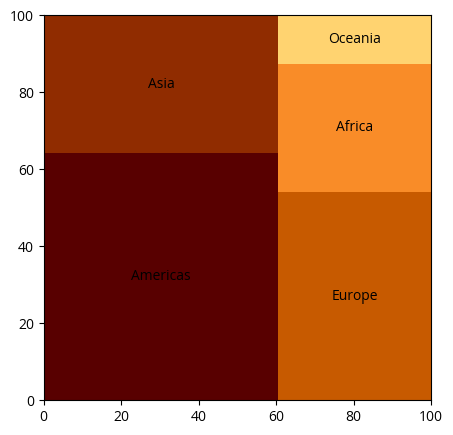

In [90]:
label_list = []
cost_by_region_TOTAL_sum.index.tolist()
#for 

fig = mp.figure(figsize=(5,5))
ax = fig.add_subplot(111)

squarify.plot(cost_by_region_TOTAL_sum['Proposed+Construction'].values/1e9,
              color=cost_by_region_TOTAL_sum['Colors'].values,
              label=cost_by_region_TOTAL_sum.index.tolist())

treemap_fig = mp.gcf()

# pie charts with costs, mtpa

## import

## big panel figure

# cumulative sum 2023 onward

In [91]:
terms_df_export_const_fid = terms_df_orig.loc[(terms_df_orig.FacilityType=='Export')&
                                                ((terms_df_orig.Status.isin(['Operating','Construction'])) |
                                                          (terms_df_orig.FIDStatus=='FID'))]

In [92]:
#terms_df_export_const_fid.to_excel('terminals-for-cumulative-sum-Dec1-2023.xlsx')

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_88302/2920323376.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sel_cmap = matplotlib.cm.get_cmap('magma')#cm.get_cmap('magma')


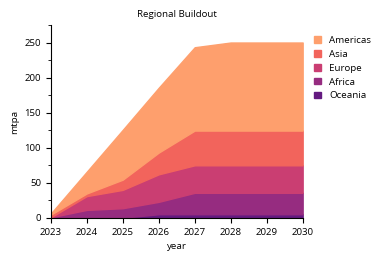

In [93]:
# fill up new capacities as they come online

start_year = 2023
end_year = 2030
year_list = range(start_year, end_year+1, 1)
mtpa_sum_regional = pandas.DataFrame(0.0, columns=region_list, index=year_list)
mtpa_sum = numpy.zeros(year_list.__len__())
mtpa_sum_americas = numpy.zeros(year_list.__len__())

for yr_idx in range(year_list.__len__()):
    terms_df_export_const_fid_subset = terms_df_export_const_fid.loc[terms_df_export_const_fid.StartYearEarliest==year_list[yr_idx]]
    mtpa_sum_regional.loc[year_list[yr_idx]] = terms_df_export_const_fid_subset.groupby('Region')['CapacityInMtpa'].sum()
    
    terms_df_export_const_fid_subset_americas = terms_df_export_const_fid.loc[(terms_df_export_const_fid.StartYearEarliest==year_list[yr_idx])&
                                           (terms_df_export_const_fid.Region=='Americas')]
    mtpa_sum_americas[yr_idx:] += terms_df_export_const_fid_subset_americas['CapacityInMtpa'].sum()

mtpa_sum_regional.replace(numpy.nan, 0.0, inplace=True)
mtpa_sum_regional_cumsum = mtpa_sum_regional.cumsum()
mtpa_sum_regional_cumsum.sort_values(axis='columns', by=year_list[-1], inplace=True)
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum.cumsum(axis=1)
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum_byregion.loc[:, (mtpa_sum_regional_cumsum_byregion != 0).any(axis=0)]

region_list = mtpa_sum_regional_cumsum.columns.values

# ****************************************

font_size = 7
fig = mp.figure(figsize=(3.25,2.5))
#fig = mp.figure(figsize=(3.25,4))

ax = fig.add_subplot(111)
ax.set_xlim(start_year, end_year)
ax.set_ylim(0,275)

#new_region_list = mtpa_sum_regional_cumsum_byregion.columns
sel_cmap = matplotlib.cm.get_cmap('magma')#cm.get_cmap('magma')
region_colors = [sel_cmap(i) for i in numpy.linspace(0.3,0.8,region_list.__len__())]

for region_idx in range(region_list.__len__()):
    if region_idx==0:
        ax.fill_between(year_list, 
                        0, 
                        mtpa_sum_regional_cumsum_byregion[region_list[region_idx]],
                        color=region_colors[region_idx], 
                        label=region_list[region_idx])
    # else:
    #     if new_region_list[region_idx]=='North America':
    #         ax.fill_between(year_list, 
    #                     mtpa_sum_regional_cumsum_byregion[new_region_list[-2]], 
    #                     mtpa_sum_regional_cumsum_byregion[new_region_list[-2]]+mtpa_sum_rest_of_nam,
    #                     color=matplotlib.cm.get_cmap('magma')(0.2), 
    #                     label='Other North America')
    #         ax.fill_between(year_list,
    #                     mtpa_sum_regional_cumsum_byregion[new_region_list[-2]]+mtpa_sum_rest_of_nam,
    #                     mtpa_sum_regional_cumsum_byregion[new_region_list[-2]]+mtpa_sum_rest_of_nam+mtpa_sum_usa,
    #                     color=matplotlib.cm.get_cmap('magma')(0.3), 
    #                     label='United States')    
    else:
        ax.fill_between(year_list, 
                    mtpa_sum_regional_cumsum_byregion[region_list[region_idx-1]],
                    mtpa_sum_regional_cumsum_byregion[region_list[region_idx]], 
                    color=region_colors[region_idx], 
                    label=region_list[region_idx])

ax.tick_params(labelsize=font_size)
ax.set_ylabel('mtpa', size=font_size)
ax.set_xlabel('year', size=font_size)
#ax.yaxis.grid(linestyle='--')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax_h, ax_l = ax.get_legend_handles_labels()
#ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.01,0.99))
ax.legend(ax_h[::-1],
          ax_l[::-1],
          fontsize=font_size, frameon=False, 
          handlelength=0.75, loc='upper left', bbox_to_anchor=(1.01,0.99))
ax.set_title('Regional Buildout', size=font_size)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

mp.savefig('saved-figures/mtpa-regional-export-timeseries.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/mtpa-regional-export-timeseries.pdf', bbox_inches='tight', transparent=True)
mp.savefig('saved-figures/mtpa-regional-export-timeseries.svg', bbox_inches='tight', transparent=True)

# FIGURE - CUMSUM FOR 5 LEADING COUNTRIES

In [94]:
start_year = 2023
end_year = 2030
year_list = range(start_year, end_year+1, 1)
mtpa_sum_country = pandas.DataFrame(0.0, columns=country_list, index=year_list)
mtpa_sum = numpy.zeros(year_list.__len__())

for yr_idx in range(year_list.__len__()):
    terms_df_export_const_fid_subset = terms_df_export_const_fid.loc[terms_df_export_const_fid.StartYearEarliest==year_list[yr_idx]]
    mtpa_sum_country.loc[year_list[yr_idx]] = terms_df_export_const_fid_subset.groupby('Country')['CapacityInMtpa'].sum()

mtpa_sum_country.replace(numpy.nan, 0.0, inplace=True)
mtpa_sum_country_cumsum = mtpa_sum_country.cumsum()
mtpa_sum_country_cumsum.sort_values(axis='columns', by=year_list[-1], inplace=True)
mtpa_sum_country_cumsum_relative_vals = mtpa_sum_country_cumsum.cumsum(axis=1)
mtpa_sum_country_cumsum_relative_vals = mtpa_sum_country_cumsum_relative_vals.loc[:, (mtpa_sum_country_cumsum_relative_vals != 0).any(axis=0)]

## print out values

In [95]:
mtpa_sum_country_cumsum.loc[:, (mtpa_sum_country_cumsum != 0).any(axis=0)]

,Morocco,Gabon,Malaysia,Mauritania,Suriname,Republic of the Congo,Indonesia,Australia,Mexico,Iran,Nigeria,Mozambique,Canada,Qatar,Russia,United States
2023,0.00,0.0,0.0,0.00,0.0,0.6,3.8,0.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.15
2024,0.07,0.0,0.0,2.52,2.7,0.6,3.8,0.0,2.80,0.0,8.0,0.0,0.0,0.0,19.7,25.54
2025,0.07,0.0,0.0,2.52,2.7,3.0,3.8,0.0,8.85,10.8,8.0,0.0,28.0,0.0,26.2,31.57
2026,0.07,0.7,0.0,2.52,2.7,3.0,3.8,5.0,8.85,10.8,11.4,0.0,28.0,16.5,39.3,53.05
2027,0.07,0.7,2.0,2.52,2.7,3.0,3.8,5.0,8.85,10.8,11.4,12.9,30.1,33.0,39.3,77.41
2028,0.07,0.7,2.0,2.52,2.7,3.0,3.8,5.0,8.85,10.8,11.4,12.9,30.1,33.0,39.3,84.16
2029,0.07,0.7,2.0,2.52,2.7,3.0,3.8,5.0,8.85,10.8,11.4,12.9,30.1,33.0,39.3,84.16
2030,0.07,0.7,2.0,2.52,2.7,3.0,3.8,5.0,8.85,10.8,11.4,12.9,30.1,33.0,39.3,84.16


In [96]:
mtpa_sum_country_cumsum.cumsum(axis=1)

,Afghanistan,Nauru,Nepal,Netherlands,New Caledonia,New Zealand,Nicaragua,Niger,Niue,Norfolk Island,...,Indonesia,Australia,Mexico,Iran,Nigeria,Mozambique,Canada,Qatar,Russia,United States
2023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.40,4.40,5.80,5.80,5.80,5.80,5.80,5.80,5.80,5.95
2024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.69,9.69,12.49,12.49,20.49,20.49,20.49,20.49,40.19,65.73
2025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.09,12.09,20.94,31.74,39.74,39.74,67.74,67.74,93.94,125.51
2026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.79,17.79,26.64,37.44,48.84,48.84,76.84,93.34,132.64,185.69
2027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.79,19.79,28.64,39.44,50.84,63.74,93.84,126.84,166.14,243.55
2028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.79,19.79,28.64,39.44,50.84,63.74,93.84,126.84,166.14,250.30
2029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.79,19.79,28.64,39.44,50.84,63.74,93.84,126.84,166.14,250.30
2030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.79,19.79,28.64,39.44,50.84,63.74,93.84,126.84,166.14,250.30


In [97]:
top_n = 8
mtpa_sum_country_cumsum_top_n = mtpa_sum_country_cumsum.iloc[:,-top_n:]
mtpa_sum_country_cumsum_the_rest = mtpa_sum_country_cumsum.iloc[:,:-top_n]

mtpa_sum_country_cumsum_relative_vals_top_n = mtpa_sum_country_cumsum.cumsum(axis=1).iloc[:,-top_n:]
#mtpa_sum_country_cumsum_relative_vals_top_n = mtpa_sum_country_cumsum_relative_vals_top_n.loc[:, (mtpa_sum_country_cumsum_relative_vals_top_n != 0).any(axis=0)]
mtpa_sum_country_cumsum_relative_vals_top_n

,Mexico,Iran,Nigeria,Mozambique,Canada,Qatar,Russia,United States
2023,5.80,5.80,5.80,5.80,5.80,5.80,5.80,5.95
2024,12.49,12.49,20.49,20.49,20.49,20.49,40.19,65.73
2025,20.94,31.74,39.74,39.74,67.74,67.74,93.94,125.51
2026,26.64,37.44,48.84,48.84,76.84,93.34,132.64,185.69
2027,28.64,39.44,50.84,63.74,93.84,126.84,166.14,243.55
2028,28.64,39.44,50.84,63.74,93.84,126.84,166.14,250.30
2029,28.64,39.44,50.84,63.74,93.84,126.84,166.14,250.30
2030,28.64,39.44,50.84,63.74,93.84,126.84,166.14,250.30


## relative values for "the rest"

In [98]:
mtpa_sum_country_cumsum_relative_vals_the_rest = pandas.DataFrame(mtpa_sum_country_cumsum_the_rest.sum(axis=1))
mtpa_sum_country_cumsum_relative_vals_the_rest.rename(columns={0:'Other'}, inplace=True)
mtpa_sum_country_cumsum_relative_vals_the_rest

,Other
2023,4.40
2024,9.69
2025,12.09
2026,17.79
2027,19.79
2028,19.79
2029,19.79
2030,19.79


In [99]:
mtpa_sum_country_cumsum_relative_vals_the_rest_and_top_n = pandas.concat([mtpa_sum_country_cumsum_relative_vals_the_rest,
                                                                          mtpa_sum_country_cumsum_relative_vals_top_n], axis=1)

mtpa_sum_country_cumsum_relative_vals_the_rest_and_top_n

,Other,Mexico,Iran,Nigeria,Mozambique,Canada,Qatar,Russia,United States
2023,4.40,5.80,5.80,5.80,5.80,5.80,5.80,5.80,5.95
2024,9.69,12.49,12.49,20.49,20.49,20.49,20.49,40.19,65.73
2025,12.09,20.94,31.74,39.74,39.74,67.74,67.74,93.94,125.51
2026,17.79,26.64,37.44,48.84,48.84,76.84,93.34,132.64,185.69
2027,19.79,28.64,39.44,50.84,63.74,93.84,126.84,166.14,243.55
2028,19.79,28.64,39.44,50.84,63.74,93.84,126.84,166.14,250.30
2029,19.79,28.64,39.44,50.84,63.74,93.84,126.84,166.14,250.30
2030,19.79,28.64,39.44,50.84,63.74,93.84,126.84,166.14,250.30


/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_88302/1380259723.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sel_cmap = matplotlib.cm.get_cmap('magma')#cm.get_cmap('magma')


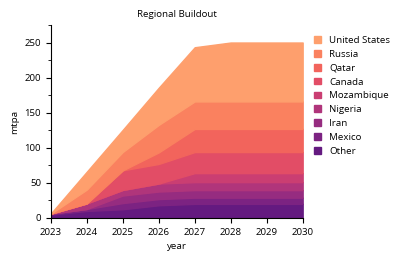

In [100]:
# ****************************************

font_size = 7
fig = mp.figure(figsize=(3.25,2.5))
#fig = mp.figure(figsize=(3.25,4))

ax = fig.add_subplot(111)
ax.set_xlim(start_year, end_year)
ax.set_ylim(0,275)

#new_region_list = mtpa_sum_regional_cumsum_byregion.columns
sel_cmap = matplotlib.cm.get_cmap('magma')#cm.get_cmap('magma')
wedge_list = mtpa_sum_country_cumsum_relative_vals_the_rest_and_top_n.columns.tolist()
wedge_colors = [sel_cmap(i) for i in numpy.linspace(0.3,0.8,wedge_list.__len__())]

for wedge_idx in range(wedge_list.__len__()):
    if wedge_idx==0:
        ax.fill_between(year_list, 
                        0, 
                        mtpa_sum_country_cumsum_relative_vals_the_rest_and_top_n[wedge_list[wedge_idx]],
                        color=wedge_colors[wedge_idx], 
                        label=wedge_list[wedge_idx])
    # else:
    #     if new_region_list[region_idx]=='North America':
    #         ax.fill_between(year_list, 
    #                     mtpa_sum_regional_cumsum_byregion[new_region_list[-2]], 
    #                     mtpa_sum_regional_cumsum_byregion[new_region_list[-2]]+mtpa_sum_rest_of_nam,
    #                     color=matplotlib.cm.get_cmap('magma')(0.2), 
    #                     label='Other North America')
    #         ax.fill_between(year_list,
    #                     mtpa_sum_regional_cumsum_byregion[new_region_list[-2]]+mtpa_sum_rest_of_nam,
    #                     mtpa_sum_regional_cumsum_byregion[new_region_list[-2]]+mtpa_sum_rest_of_nam+mtpa_sum_usa,
    #                     color=matplotlib.cm.get_cmap('magma')(0.3), 
    #                     label='United States')    
    else:
        ax.fill_between(year_list, 
                    mtpa_sum_country_cumsum_relative_vals_the_rest_and_top_n[wedge_list[wedge_idx-1]],
                    mtpa_sum_country_cumsum_relative_vals_the_rest_and_top_n[wedge_list[wedge_idx]], 
                    color=wedge_colors[wedge_idx], 
                    label=wedge_list[wedge_idx])

ax.tick_params(labelsize=font_size)
ax.set_ylabel('mtpa', size=font_size)
ax.set_xlabel('year', size=font_size)
#ax.yaxis.grid(linestyle='--')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax_h, ax_l = ax.get_legend_handles_labels()
#ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.01,0.99))
ax.legend(ax_h[::-1],
          ax_l[::-1],
          fontsize=font_size, frameon=False, 
          handlelength=0.75, loc='upper left', bbox_to_anchor=(1.01,0.99))
ax.set_title('Regional Buildout', size=font_size)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

# mp.savefig('saved-figures/mtpa-regional-export-timeseries.png', bbox_inches='tight', transparent=True, dpi=600)
# mp.savefig('saved-figures/mtpa-regional-export-timeseries.pdf', bbox_inches='tight', transparent=True)
# mp.savefig('saved-figures/mtpa-regional-export-timeseries.svg', bbox_inches='tight', transparent=True)

# same but for subregions

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_88302/119673973.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sel_cmap = matplotlib.cm.get_cmap('magma')#cm.get_cmap('magma')


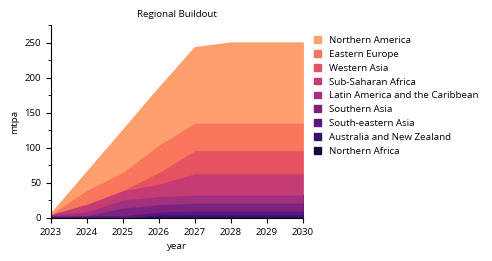

In [101]:
# fill up new capacities as they come online
start_year = 2023
end_year = 2030
year_list = range(start_year, end_year+1, 1)
mtpa_sum_regional = pandas.DataFrame(0.0, columns=subregion_list, index=year_list)
mtpa_sum = numpy.zeros(year_list.__len__())
mtpa_sum_americas = numpy.zeros(year_list.__len__())

for yr_idx in range(year_list.__len__()):
    terms_df_export_const_fid_subset = terms_df_export_const_fid.loc[terms_df_export_const_fid.StartYearEarliest==year_list[yr_idx]]
    mtpa_sum_regional.loc[year_list[yr_idx]] = terms_df_export_const_fid_subset.groupby('SubRegion')['CapacityInMtpa'].sum()

mtpa_sum_regional.replace(numpy.nan, 0.0, inplace=True)
mtpa_sum_regional_cumsum = mtpa_sum_regional.cumsum()
mtpa_sum_regional_cumsum.sort_values(axis='columns', by=year_list[-1], inplace=True)
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum.cumsum(axis=1)
#eliminate all-zero columns
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum_byregion.loc[:, (mtpa_sum_regional_cumsum_byregion != 0).any(axis=0)]

# ****************************************

font_size = 7
fig = mp.figure(figsize=(3.25,2.5))

ax = fig.add_subplot(111)
ax.set_xlim(start_year, end_year)
ax.set_ylim(0,275)

new_subregion_list = mtpa_sum_regional_cumsum_byregion.columns
sel_cmap = matplotlib.cm.get_cmap('magma')#cm.get_cmap('magma')
region_colors = [sel_cmap(i) for i in numpy.linspace(0.1,0.8,new_subregion_list.__len__())]

for subregion_idx in range(new_subregion_list.__len__()):
    if subregion_idx==0:
        ax.fill_between(year_list, 
                        0, 
                        mtpa_sum_regional_cumsum_byregion[new_subregion_list[region_idx]],
                        color=region_colors[subregion_idx], 
                        label=new_subregion_list[subregion_idx])
    else:
        ax.fill_between(year_list, 
                    mtpa_sum_regional_cumsum_byregion[new_subregion_list[subregion_idx-1]],
                    mtpa_sum_regional_cumsum_byregion[new_subregion_list[subregion_idx]], 
                    color=region_colors[subregion_idx], 
                    label=new_subregion_list[subregion_idx])

ax.tick_params(labelsize=font_size)
ax.set_ylabel('mtpa', size=font_size)
ax.set_xlabel('year', size=font_size)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_h[::-1],
          ax_l[::-1],
          fontsize=font_size, frameon=False, 
          handlelength=0.75, loc='upper left', bbox_to_anchor=(1.01,0.99))
ax.set_title('Regional Buildout', size=font_size)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

mp.savefig('saved-figures/mtpa-subregional-export-timeseries.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/mtpa-subregional-export-timeseries.pdf', bbox_inches='tight', transparent=True)
mp.savefig('saved-figures/mtpa-subregional-export-timeseries.svg', bbox_inches='tight', transparent=True)

In [102]:
mtpa_sum_regional_cumsum.loc[:,(mtpa_sum_regional_cumsum!= 0).any(axis=0)]

,Northern Africa,Australia and New Zealand,South-eastern Asia,Southern Asia,Latin America and the Caribbean,Sub-Saharan Africa,Western Asia,Eastern Europe,Northern America
2023,0.00,0.0,3.8,0.0,1.40,0.60,0.0,0.0,0.15
2024,0.07,0.0,3.8,0.0,5.50,11.12,0.0,19.7,25.54
2025,0.07,0.0,3.8,10.8,11.55,13.52,0.0,26.2,59.57
2026,0.07,5.0,3.8,10.8,11.55,17.62,16.5,39.3,81.05
2027,0.07,5.0,5.8,10.8,11.55,30.52,33.0,39.3,107.51
2028,0.07,5.0,5.8,10.8,11.55,30.52,33.0,39.3,114.26
2029,0.07,5.0,5.8,10.8,11.55,30.52,33.0,39.3,114.26
2030,0.07,5.0,5.8,10.8,11.55,30.52,33.0,39.3,114.26


/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_88302/1264861184.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sel_cmap = matplotlib.cm.get_cmap('magma')#cm.get_cmap('magma')
/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_88302/1264861184.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color=matplotlib.cm.get_cmap('magma')(0.3),
/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_88302/1264861184.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)

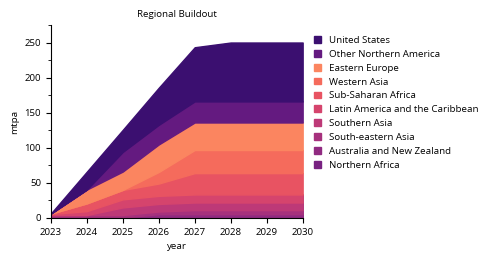

In [103]:
# fill up new capacities as they come online
start_year = 2023
end_year = 2030
year_list = range(start_year, end_year+1, 1)
mtpa_sum_regional = pandas.DataFrame(0.0, columns=subregion_list, index=year_list)
mtpa_sum = numpy.zeros(year_list.__len__())
mtpa_sum_usa = numpy.zeros(year_list.__len__())

for yr_idx in range(year_list.__len__()):
    terms_df_export_const_fid_subset = terms_df_export_const_fid.loc[terms_df_export_const_fid.StartYearEarliest==year_list[yr_idx]]
    mtpa_sum_regional.loc[year_list[yr_idx]] = terms_df_export_const_fid_subset.groupby('SubRegion')['CapacityInMtpa'].sum()
    
    terms_df_export_subset_usa = terms_df_export_const_fid.loc[(terms_df_export_const_fid.StartYearEarliest==year_list[yr_idx])&
                                           (terms_df_export_const_fid.Country=='United States')]
    
    mtpa_sum_usa[yr_idx:] += terms_df_export_subset_usa['CapacityInMtpa'].sum()

mtpa_sum_regional.replace(numpy.nan, 0.0, inplace=True)
mtpa_sum_regional_cumsum = mtpa_sum_regional.cumsum()
mtpa_sum_regional_cumsum.sort_values(axis='columns', by=year_list[-1], inplace=True)
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum.cumsum(axis=1)
#eliminate all-zero columns
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum_byregion.loc[:, (mtpa_sum_regional_cumsum_byregion != 0).any(axis=0)]

mtpa_sum_rest_of_nam = mtpa_sum_regional_cumsum['Northern America'].values - mtpa_sum_usa

# ****************************************

font_size = 7
fig = mp.figure(figsize=(3.25,2.5))

ax = fig.add_subplot(111)
ax.set_xlim(start_year, end_year)
ax.set_ylim(0,275)

new_subregion_list = mtpa_sum_regional_cumsum_byregion.columns
sel_cmap = matplotlib.cm.get_cmap('magma')#cm.get_cmap('magma')
region_colors = [sel_cmap(i) for i in numpy.linspace(0.35,0.8,new_subregion_list.__len__())]

for subregion_idx in range(new_subregion_list.__len__()):
    if subregion_idx==0:
        ax.fill_between(year_list, 
                        0, 
                        mtpa_sum_regional_cumsum_byregion[new_subregion_list[region_idx]],
                        color=region_colors[subregion_idx], 
                        label=new_subregion_list[subregion_idx])
    elif new_subregion_list[subregion_idx]=='Northern America':
            #pass
            #do the north america not USA chunk
            ax.fill_between(year_list, 
                        mtpa_sum_regional_cumsum_byregion[new_subregion_list[-2]], 
                        mtpa_sum_regional_cumsum_byregion[new_subregion_list[-2]]+mtpa_sum_rest_of_nam,
                        color=matplotlib.cm.get_cmap('magma')(0.3), 
                        label='Other Northern America')
            ax.fill_between(year_list,
                        mtpa_sum_regional_cumsum_byregion[new_subregion_list[-2]]+mtpa_sum_rest_of_nam,
                        mtpa_sum_regional_cumsum_byregion[new_subregion_list[-2]]+mtpa_sum_rest_of_nam+mtpa_sum_usa,
                        color=matplotlib.cm.get_cmap('magma')(0.2), 
                        label='United States')   
    else:
        ax.fill_between(year_list, 
                    mtpa_sum_regional_cumsum_byregion[new_subregion_list[subregion_idx-1]],
                    mtpa_sum_regional_cumsum_byregion[new_subregion_list[subregion_idx]], 
                    color=region_colors[subregion_idx], 
                    label=new_subregion_list[subregion_idx])

ax.tick_params(labelsize=font_size)
ax.set_ylabel('mtpa', size=font_size)
ax.set_xlabel('year', size=font_size)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_h[::-1],
          ax_l[::-1],
          fontsize=font_size, frameon=False, 
          handlelength=0.75, loc='upper left', bbox_to_anchor=(1.01,0.99))
ax.set_title('Regional Buildout', size=font_size)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

mp.savefig('saved-figures/mtpa-subregional-export-timeseries-usa.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/mtpa-subregional-export-timeseries-usa.pdf', bbox_inches='tight', transparent=True)
mp.savefig('saved-figures/mtpa-subregional-export-timeseries-usa.svg', bbox_inches='tight', transparent=True)

In [104]:
mtpa_sum_regional_cumsum_byregion

,Northern Africa,Australia and New Zealand,South-eastern Asia,Southern Asia,Latin America and the Caribbean,Sub-Saharan Africa,Western Asia,Eastern Europe,Northern America
2023,0.00,0.00,3.80,3.80,5.20,5.80,5.80,5.80,5.95
2024,0.07,0.07,3.87,3.87,9.37,20.49,20.49,40.19,65.73
2025,0.07,0.07,3.87,14.67,26.22,39.74,39.74,65.94,125.51
2026,0.07,5.07,8.87,19.67,31.22,48.84,65.34,104.64,185.69
2027,0.07,5.07,10.87,21.67,33.22,63.74,96.74,136.04,243.55
2028,0.07,5.07,10.87,21.67,33.22,63.74,96.74,136.04,250.30
2029,0.07,5.07,10.87,21.67,33.22,63.74,96.74,136.04,250.30
2030,0.07,5.07,10.87,21.67,33.22,63.74,96.74,136.04,250.30


In [105]:
pandas.DataFrame(numpy.column_stack((mtpa_sum_usa,mtpa_sum_rest_of_nam)), index=range(2023,2031), columns=['United States', 'Other Northern America'])

,United States,Other Northern America
2023,0.15,0.0
2024,25.54,0.0
2025,31.57,28.0
2026,53.05,28.0
2027,77.41,30.1
2028,84.16,30.1
2029,84.16,30.1
2030,84.16,30.1


# final read-through report number checks

In [106]:
terms_df_orig.loc[(terms_df_orig.Status.isin(['Operating']))&
                  (terms_df_orig.StartYear1.isin([2022,2023]))&
                  (terms_df_orig['FacilityType']=='Import')]['CapacityInMtpa'].sum()

121.81000000000002

In [107]:
terms_df_orig.loc[(terms_df_orig.Status.isin(['Operating']))&
                  (terms_df_orig.StartYear1.isin([2022,2023]))&
                  (terms_df_orig['FacilityType']=='Export')]['CapacityInMtpa'].sum()

15.46

In [108]:
terms_df_orig.loc[(terms_df_orig.Status.isin(['Proposed','Construction']))&
                  (terms_df_orig.Delayed=='Yes')]['CapacityInMtpa'].sum()

579.4200000000001

In [109]:
terms_df_orig.loc[(terms_df_orig.Status.isin(['Shelved']))]['CapacityInMtpa'].sum()

203.97

In [110]:
terms_df_orig.loc[(terms_df_orig.Status.isin(['Shelved']))&
                  (terms_df_orig.ShelvedYear.isin([2022,2023]))]['CapacityInMtpa'].sum()

101.62999999999998

In [111]:
terms_df_orig.loc[(terms_df_orig.Status.isin(['Cancelled']))&
                  (terms_df_orig.CancelledYear.isin([2022,2023]))]['CapacityInMtpa'].sum()

127.30000000000001

In [112]:
cost_by_country_export_df

,,,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Region,SubRegion,Country,,,,,,,,,
Americas,Northern America,United States,1.869357e+11,5.922098e+10,2.461567e+11,4.000000e+09,1.385146e+11,7.264421e+10,0.000000e+00,1.105136e+09,0.000000e+00
Europe,Eastern Europe,Russia,1.535972e+11,3.930903e+10,1.929062e+11,1.581147e+10,1.882763e+10,4.762195e+10,5.880000e+08,0.000000e+00,0.000000e+00
Americas,Northern America,Canada,5.718606e+10,2.110000e+10,7.828606e+10,0.000000e+00,1.974419e+11,3.683787e+07,0.000000e+00,0.000000e+00,0.000000e+00
Africa,Sub-Saharan Africa,Mozambique,5.089145e+10,0.000000e+00,5.089145e+10,0.000000e+00,0.000000e+00,7.000000e+09,0.000000e+00,0.000000e+00,0.000000e+00
Americas,Latin America and the Caribbean,Mexico,4.656741e+10,3.694461e+09,5.026187e+10,0.000000e+00,3.683787e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Asia,Western Asia,Qatar,1.750000e+10,2.875000e+10,4.625000e+10,0.000000e+00,0.000000e+00,5.731234e+10,0.000000e+00,0.000000e+00,0.000000e+00
Africa,Sub-Saharan Africa,Tanzania,4.200000e+10,0.000000e+00,4.200000e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Oceania,Australia and New Zealand,Australia,2.813767e+10,5.600000e+09,3.373767e+10,1.725000e+10,3.368874e+10,1.801663e+11,0.000000e+00,0.000000e+00,0.000000e+00
Americas,Latin America and the Caribbean,Argentina,3.000000e+10,0.000000e+00,3.000000e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.837168e+08,0.000000e+00


# Greig's thoughts on showing decreased construction?

(0.0, 120.0)

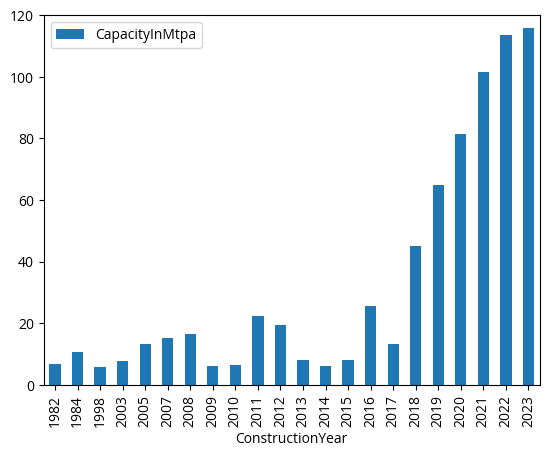

In [113]:
which_region = 'Asia'
which_status = 'Construction'

fig = terms_df_orig.loc[#(terms_df_orig.Status==which_status)&
                (terms_df_orig.Status.isin(['Construction','Operating']))
                #(terms_df_orig.Region==which_region)
                ].groupby('ConstructionYear')[['CapacityInMtpa']].sum().iloc[:-1,:].plot.bar()
fig.set_ylim(0,120)

(0.0, 80.0)

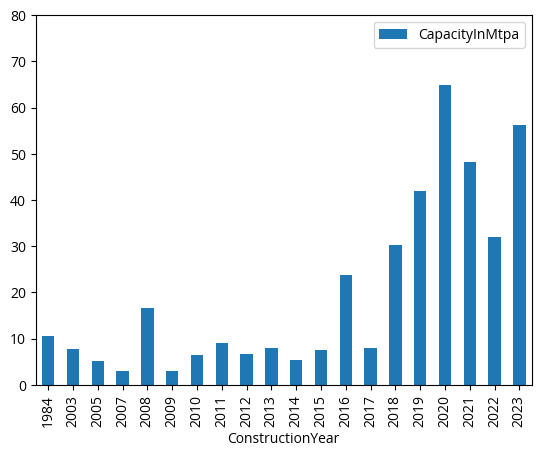

In [114]:
which_region = 'Asia'
which_status = 'Construction'

fig = terms_df_orig.loc[#(terms_df_orig.Status==which_status)&
                (terms_df_orig.Status.isin(['Construction','Operating']))&
                (terms_df_orig.Region==which_region)
                ].groupby('ConstructionYear')[['CapacityInMtpa']].sum().iloc[:-1,:].plot.bar()
fig.set_ylim(0,80)

(0.0, 80.0)

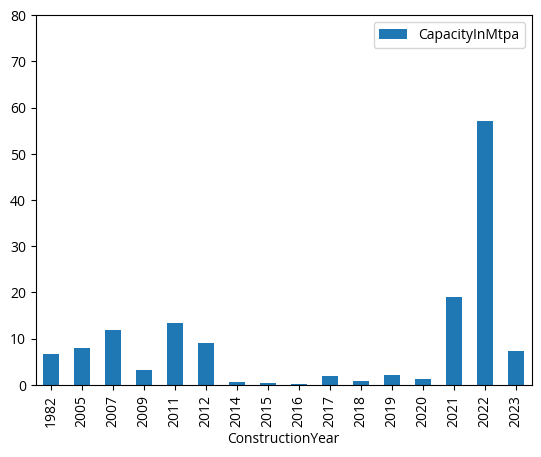

In [115]:
which_region = 'Asia'
which_status = 'Construction'

fig = terms_df_orig.loc[#(terms_df_orig.Status==which_status)&
                (terms_df_orig.Status.isin(['Construction','Operating']))&
                (terms_df_orig.Region!=which_region)&
                (terms_df_orig.FacilityType=='Import')
                ].groupby('ConstructionYear')[['CapacityInMtpa']].sum().iloc[:-1,:].plot.bar()
fig.set_ylim(0,80)